In [ ]:
from typing import Annotated   #connect to drive folder
from google.colab import drive

drive.mount('/gdrive', force_remount=True)
%cd /gdrive/My Drive/AN2DL Mattia/HW1

Mounted at /gdrive
/gdrive/My Drive/AN2DL Mattia/HW1


In [ ]:
#IMPORT LIBRARIES

# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
from PIL import Image
import matplotlib.gridspec as gridspec
from sklearn.utils.class_weight import compute_class_weight

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

2.17.1


In [ ]:
#LOAD DATA
data = np.load('Copia di training_set.npz')
X = data['images']
y = data['labels']

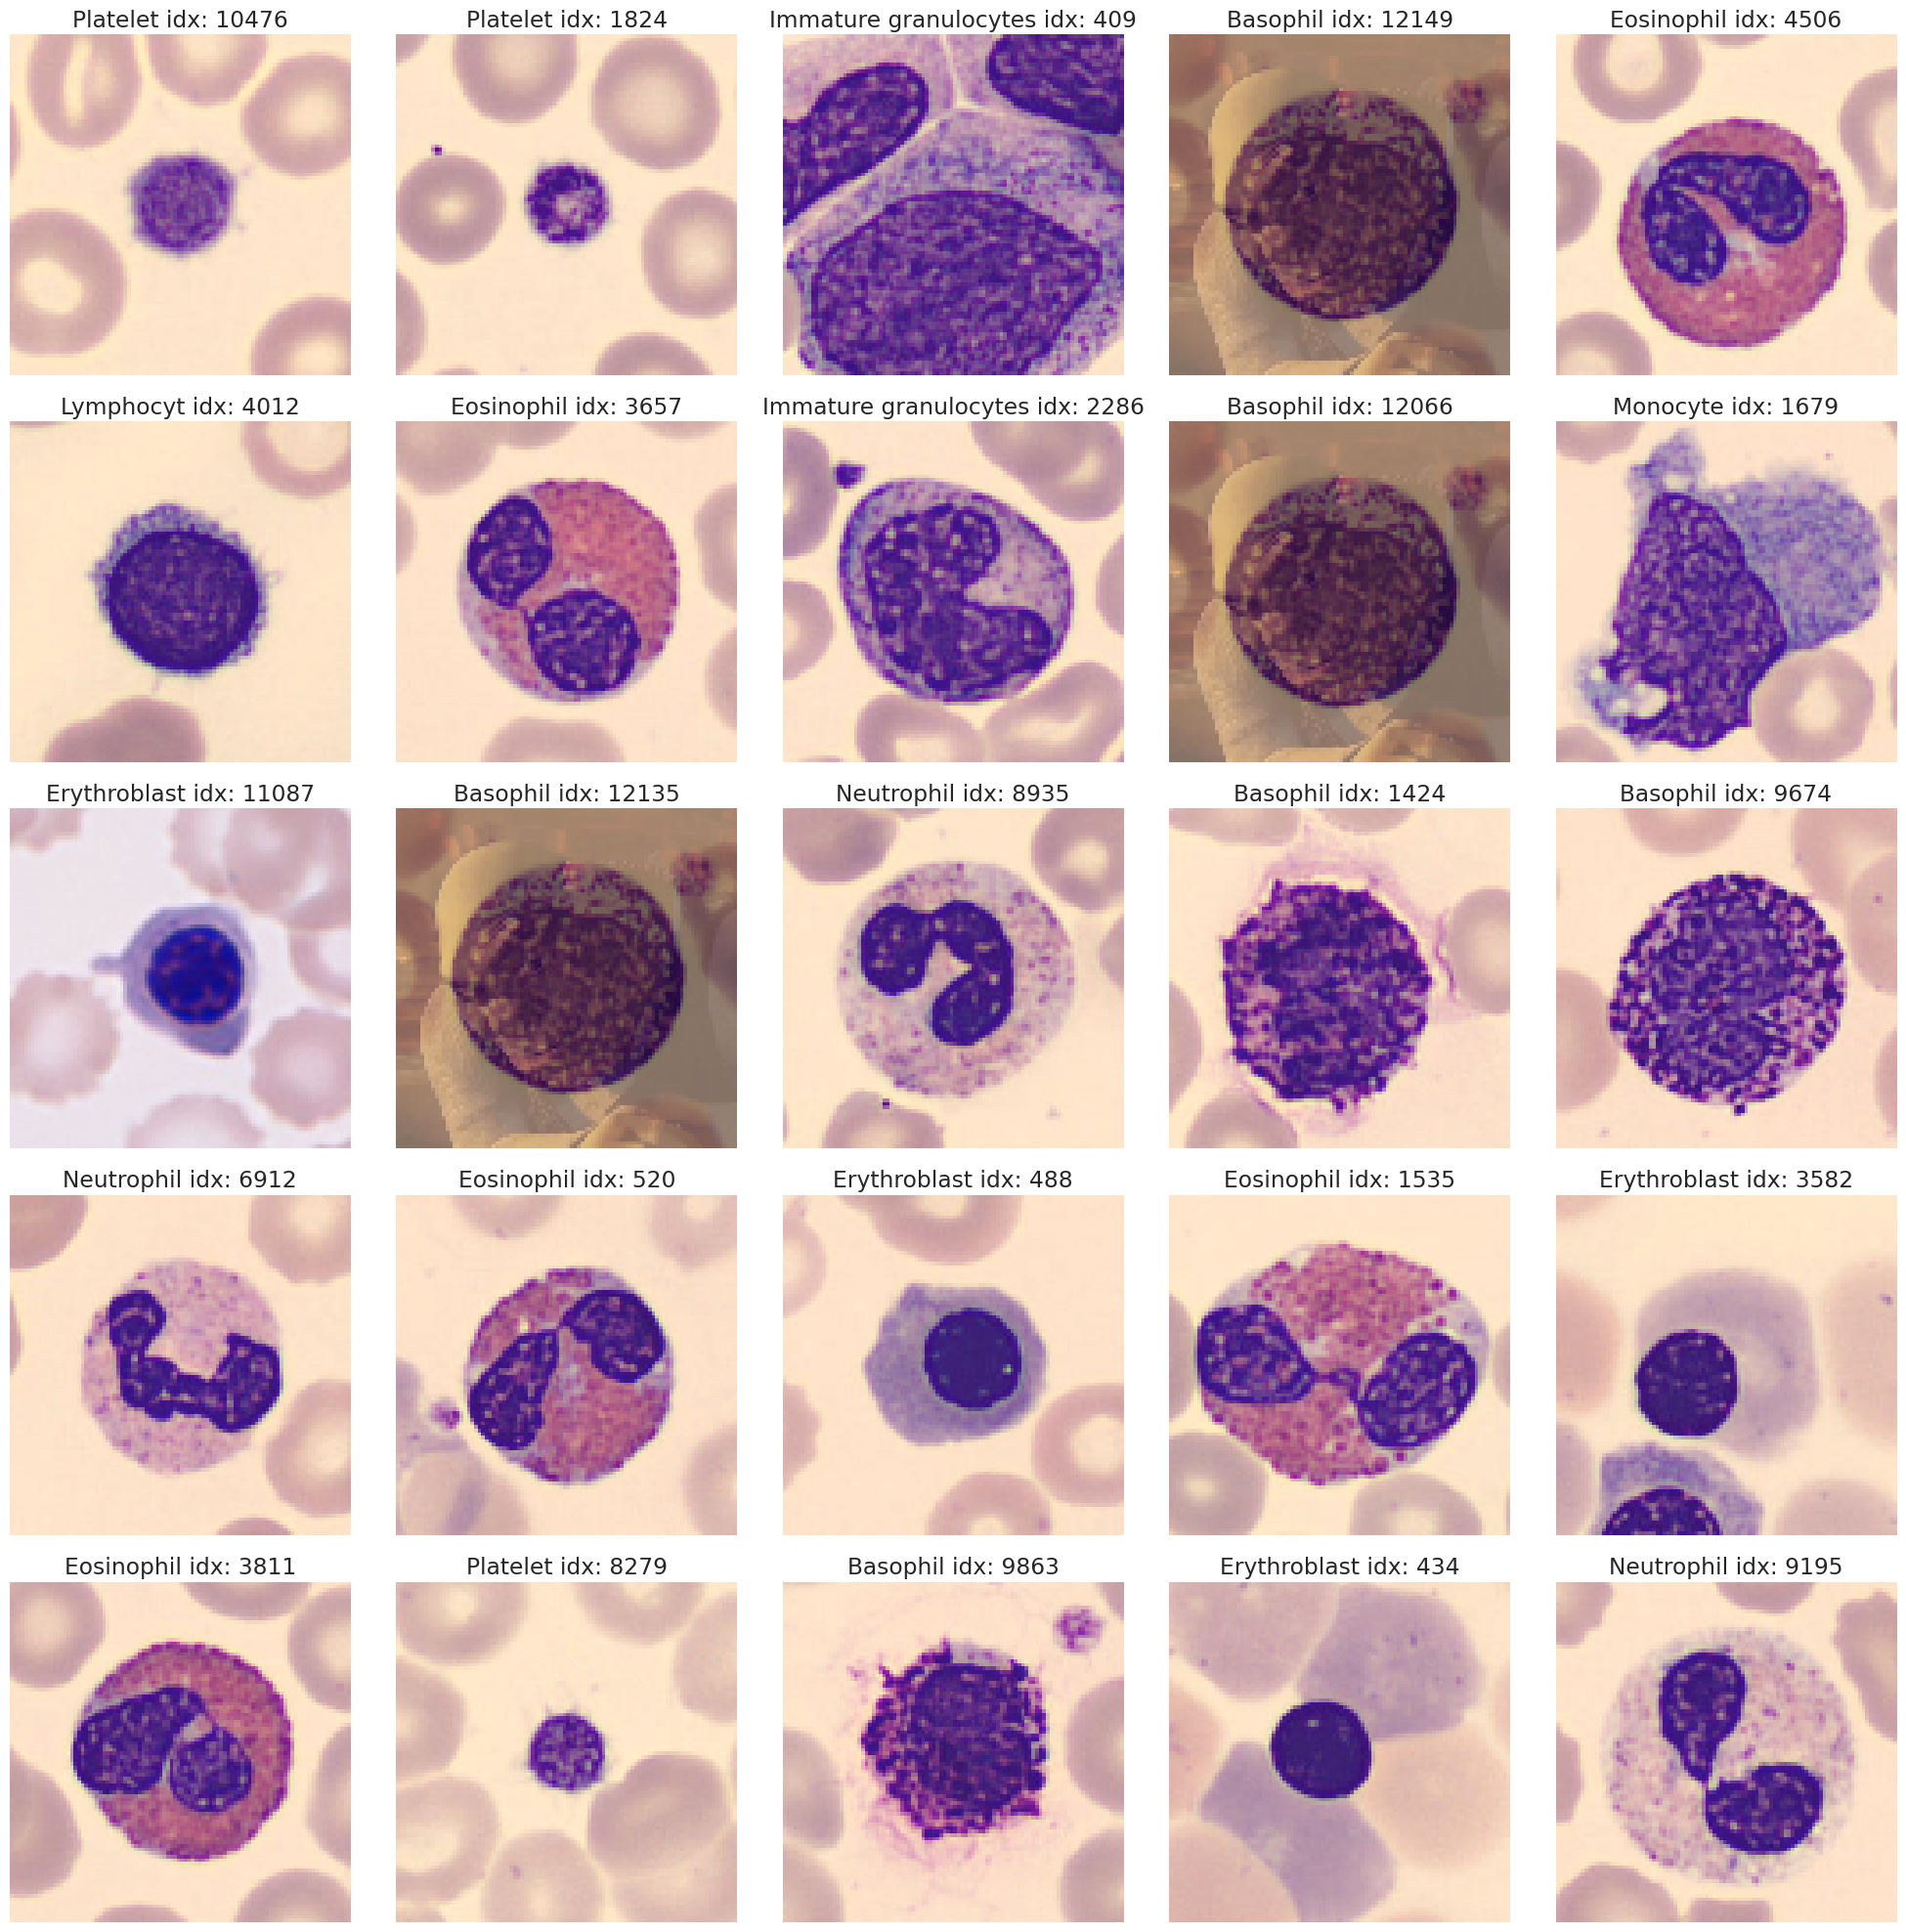

Counting occurrences of target classes:
digit
6    2530
1    2381
3    2226
7    1843
5    1393
2    1285
0    1052
4    1049
Name: count, dtype: int64


In [ ]:
# Define a mapping of labels to their corresponding digit names
labels = {0:'Basophil', 1:'Eosinophil', 2:'Erythroblast', 3:'Immature granulocytes', 4:'Lymphocyt', 5:'Monocyte', 6:'Neutrophil', 7:'Platelet'}

# Save unique labels
unique_labels = list(labels.values())

# Display a sample of images from the dataset
num_img = 25
random_indices = random.sample(range(len(X)), num_img)
fig, axes = plt.subplots(5, 5, figsize=(20, 20))

# Iterate through the selected number of images
for i, idx in enumerate(random_indices):
    row, col = divmod(i, 5)
    ax = axes[row, col]
    ax.imshow(np.squeeze(X[idx]), vmin=0., vmax=1.)
    ax.set_title(f'{labels[y[idx][0]]} idx: {idx}')
    ax.axis('off')

# Adjust layout and display the images
plt.tight_layout()
plt.show()

# Inspect the target
print('Counting occurrences of target classes:')
print(pd.DataFrame(y, columns=['digit'])['digit'].value_counts())

In [ ]:
# Identify and delete images with Shrek background
Shrek_index= 13515
immagine_ripetuta = X[Shrek_index]

# Find all indices of images
indici_da_rimuovere = []
for i in range(len(X)):
    if np.array_equal(X[i], immagine_ripetuta):
        indici_da_rimuovere.append(i)

# Remove the images
X= np.delete(X, indici_da_rimuovere, axis=0)
y= np.delete(y, indici_da_rimuovere, axis=0)



In [ ]:
# Identify and delete images with Meme background
Meme_index= 11998
immagine_ripetuta = X[Meme_index]

# Find all indices of images
indici_da_rimuovere = []
for i in range(len(X)):
    if np.array_equal(X[i], immagine_ripetuta):
        indici_da_rimuovere.append(i)

# Remove the images
X= np.delete(X, indici_da_rimuovere, axis=0)
y= np.delete(y, indici_da_rimuovere, axis=0)

In [ ]:
# Display a sample of images from the dataset to see if it has been cleaned
num_img = 64
random_indices = random.sample(range(len(X)), num_img)
fig, axes = plt.subplots(8, 8, figsize=(20, 20))

# Iterate through the selected number of images
for i, idx in enumerate(random_indices):
    row, col = divmod(i, 8)
    ax = axes[row, col]
    ax.imshow(np.squeeze(X[idx]), vmin=0., vmax=1.)
    ax.set_title(f'{labels[y[idx][0]]} idx: {idx}')
    ax.axis('off')

# Adjust layout and display the images
plt.tight_layout()
plt.show()

# Inspect the target
print('Counting occurrences of target classes:')
print(pd.DataFrame(y, columns=['digit'])['digit'].value_counts())

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Normalize data to the range [0, 1]
X = (X / 255).astype('float32')

#Dividing the test set from train+val
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, random_state=seed, test_size=0.1, stratify=y)

#Splitting training and validation
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=seed, test_size=0.1, stratify=y_train_val)



# Convert labels to categorical format using one-hot encoding
y_train_val = tfk.utils.to_categorical(y_train_val)
y_test = tfk.utils.to_categorical(y_test)

y_train = tfk.utils.to_categorical(y_train)
y_val = tfk.utils.to_categorical(y_val)


print("Training and validation Data Shape:", X_train_val.shape)
print("Training and validation Label Shape:", y_train_val.shape)
print("Test Data Shape:", X_test.shape)
print("Test Label Shape:", y_test.shape)




Training and validation Data Shape: (10763, 96, 96, 3)
Training and validation Label Shape: (10763, 8)
Test Data Shape: (1196, 96, 96, 3)
Test Label Shape: (1196, 8)


In [ ]:
import numpy as np
from collections import Counter

# Converte y_train da one-hot encoded a etichette numeriche
y_train_labels = np.argmax(y_train, axis=1)

# Conta le occorrenze di ciascuna classe nel dataset di training
class_counts = Counter(y_train_labels)

# Determina la soglia per definire le classi minoritarie
# Ad esempio, puoi considerare una classe minoritaria se ha meno del 50% della media delle occorrenze
threshold = 0.8 * np.mean(list(class_counts.values()))

# Identifica le classi minoritarie in base alla soglia
minority_classes = [label for label, count in class_counts.items() if count < threshold]
minority_classes.append(3)  #hand insert class 3 as minority since was the most misclassified

print("Classi minoritarie:", minority_classes)
print("Distribuzione delle classi nel dataset di training:", class_counts)


Classi minoritarie: [2, 4, 0, 5, 3]
Distribuzione delle classi nel dataset di training: Counter({6: 1887, 1: 1767, 3: 1641, 7: 1331, 2: 878, 5: 804, 0: 690, 4: 688})


In [ ]:

# Define a sequential model for image augmentation with various geometrical transformations
augmentation = tf.keras.Sequential([
    tfkl.RandomFlip("horizontal_and_vertical"),
    tfkl.RandomTranslation(0.1,0.1),
    tfkl.RandomRotation(0.2),
], name='Augmentation')

def augment_minority_class(images):
    # Applica augmentation a una lista di immagini di classi minoritarie
    augmented_images = [augmentation(img) for img in images]
    return augmented_images

# Applica augmentation per le classi minoritarie
for class_label in minority_classes:
    # Ottieni tutte le immagini della classe minoritaria
    y_train_labels = np.argmax(y_train, axis=1)
    minority_images = X_train[y_train_labels == class_label]

    # Genera immagini augmentate per questa classe
    augmented_images = augment_minority_class(minority_images)

    # Aggiungi le immagini aumentate al dataset di training
    X_train = np.concatenate((X_train, augmented_images), axis=0)

    # Genera etichette in formato one-hot per le immagini aumentate
    augmented_labels = tf.keras.utils.to_categorical([class_label] * len(augmented_images), num_classes=y_train.shape[1])

    # Aggiungi le etichette one-hot al dataset di training
    y_train = np.concatenate((y_train, augmented_labels), axis=0)



In [ ]:
# Inspect the target
print('Counting occurrences of target classes:')
y_train_labels = np.argmax(y_train, axis=1)
print(pd.DataFrame(y_train_labels, columns=['digit'])['digit'].value_counts())

Counting occurrences of target classes:
digit
3    3282
6    1887
1    1767
2    1756
5    1608
0    1380
4    1376
7    1331
Name: count, dtype: int64


In [ ]:
# Input shape for the model
input_shape = X_train.shape[1:]

# Output shape for the model
output_shape = y_train.shape[1]

print("Input Shape:", input_shape)
print("Output Shape:", output_shape)

#################################################
# Number of training epochs
epochs = 300

# Batch size for training
batch_size = 128

# Learning rate: step size for updating the model's weights
learning_rate=4e-4

# Print the defined parameters
print("Epochs:", epochs)
print("Batch Size:", batch_size)
print("Learning Rate:", learning_rate)

Input Shape: (96, 96, 3)
Output Shape: 8
Epochs: 300
Batch Size: 128
Learning Rate: 0.0004


In [ ]:
# Initialise EfficientNetB4 model with pretrained weights, for transfer learning
efficientnet = tfk.applications.EfficientNetB4(
    input_shape=(96, 96, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)



71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Freeze all layers in EfficientNetB4 to use it solely as a feature extractor
efficientnet.trainable = False

# Define input layer with shape matching the input images
inputs = tfk.Input(shape=(96, 96, 3), name='input_layer')

#augmentation for training set
augmentation2 = tf.keras.Sequential([
    tfkl.RandomFlip("horizontal_and_vertical"),
    tfkl.RandomTranslation(0.1,0.1),
    tfkl.RandomRotation(0.2),
    tfkl.RandomContrast(0.5)
], name='Augmentation')

x = augmentation2(inputs)

# Pass augmented inputs through the EfficientNetB4 feature extractor
x = efficientnet(x)

# Regularization with Dropout and Dense layers
x = tfkl.Dense(512, activation='relu', kernel_regularizer=tfk.regularizers.l2(0.001), name='dense_512')(x)
x = tfkl.BatchNormalization()(x)
x = tfkl.Dropout(0.3)(x)

x = tfkl.Dense(256, activation='relu', kernel_regularizer=tfk.regularizers.l2(0.001), name='dense_256')(x)
x = tfkl.BatchNormalization()(x)
x = tfkl.Dropout(0.2)(x)

# Add attention mechanism
#attention_score = tfkl.Dense(1, activation='sigmoid', name='attention_score')(x)
#x = tfkl.Multiply()([x, attention_score])

# Reshape if necessary to add sequence dimension
#x = tfkl.Reshape((-1, 256))(x)  # Output shape: (batch_size, 1, 256)

# Attention mechanism
#attention_output = tfkl.MultiHeadAttention(
    #num_heads=4,   # 4 teste
    #key_dim=64,    # Ogni testa ha dimensione 64
    #dropout=0.1    # Dropout sui punteggi di attenzione
#)(x, x)

# Residual connection
#x = tfkl.Add()([x, attention_output])  # Residual connection
#x = tfkl.Flatten()(x)  # Appiattisci per layer finale

# Add final Dense layer for classification with softmax activation
outputs = tfkl.Dense(y_train.shape[-1], activation='softmax', name='dense')(x)

# Define the complete model linking input and output
tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model with categorical cross-entropy loss and AdamW optimizer
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(),optimizer=tfk.optimizers.AdamW(learning_rate=4e-4), metrics=['accuracy'])

# Display a summary of the model architecture
tl_model.summary(expand_nested=True)

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 96, 96, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Augmentation (Sequential) │ (None, 96, 96, 3)      │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│    └ random_flip_1        │ (None, 96, 96, 3)      │              0 │ -                      │
│ (RandomFlip)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│    └ random_translation_1 │ (None, 96, 96, 3)      │              0 │ -                      │
│ (RandomTranslation)       │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│    └ random_rotation_1    │ (None, 96, 96, 3)      │              0 │ -                      │
│ (RandomRotation)          │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│    └ random_contrast      │ (None, 96, 96, 3)      │              0 │ -                      │
│ (RandomContrast)          │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ efficientnetb4            │ (None, 1792)           │     17,673,823 │ Augmentation[0][0]     │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│    └ input_layer_1        │ (None, 96, 96, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│    └ rescaling            │ (None, 96, 96, 3)      │              0 │ -                      │
│ (Rescaling)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│    └ normalization        │ (None, 96, 96, 3)      │              7 │ -                      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│    └ rescaling_1          │ (None, 96, 96, 3)      │              0 │ -                      │
│ (Rescaling)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│    └ stem_conv_pad        │ (None, 97, 97, 3)      │              0 │ -                      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│    └ stem_conv (Conv2D)   │ (None, 48, 48, 48)     │          1,296 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│    └ stem_bn              │ (None, 48, 48, 48)     │            192 │ -                      │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 18,728,552 (71.44 MB)

 Trainable params: 1,053,193 (4.02 MB)

 Non-trainable params: 17,675,359 (67.43 MB)

Epoch 1/300
113/113 ━━━━━━━━━━━━━━━━━━━━ 53s 233ms/step - accuracy: 0.5133 - loss: 11.4016 - val_accuracy: 0.6945 - val_loss: 7.5494 - learning_rate: 4.0000e-04
Epoch 2/300
113/113 ━━━━━━━━━━━━━━━━━━━━ 28s 157ms/step - accuracy: 0.6902 - loss: 6.2267 - val_accuracy: 0.7001 - val_loss: 4.2900 - learning_rate: 4.0000e-04
Epoch 3/300
113/113 ━━━━━━━━━━━━━━━━━━━━ 21s 159ms/step - accuracy: 0.7268 - loss: 3.7493 - val_accuracy: 0.7753 - val_loss: 2.7692 - learning_rate: 4.0000e-04
Epoch 4/300
113/113 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.7357 - loss: 2.5792 - val_accuracy: 0.7409 - val_loss: 2.0655 - learning_rate: 4.0000e-04
Epoch 5/300
113/113 ━━━━━━━━━━━━━━━━━━━━ 18s 155ms/step - accuracy: 0.7469 - loss: 1.9316 - val_accuracy: 0.7233 - val_loss: 1.6926 - learning_rate: 4.0000e-04
Epoch 6/300
113/113 ━━━━━━━━━━━━━━━━━━━━ 21s 155ms/step - accuracy: 0.7446 - loss: 1.5776 - val_accuracy: 0.7586 - val_loss: 1.3365 - learning_rate: 4.0000e-04
Epoch 7/300
113/113 ━━━━━━━━━━━━━━━━━━━

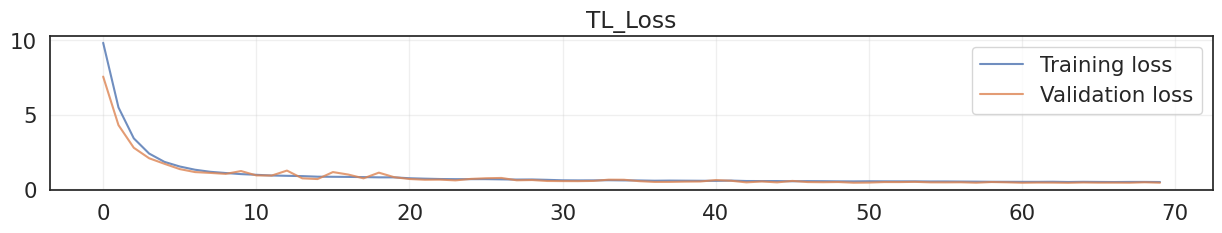

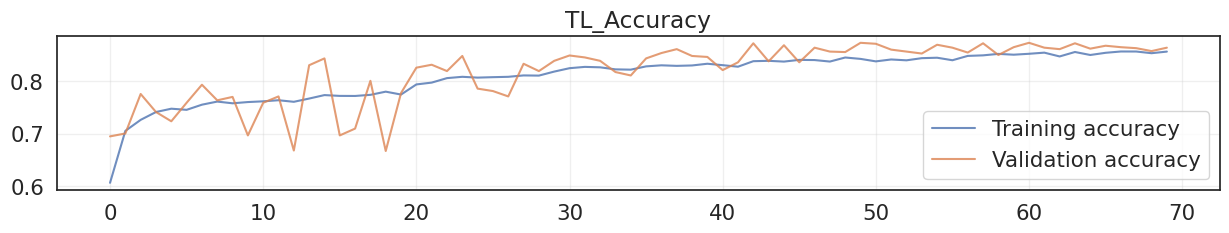

In [ ]:

# Train the model
tl_history = tl_model.fit(
    x=X_train * 255,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val * 255, y_val),
    callbacks=[tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True),
               tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)]
).history

# Calculate and print the best validation accuracy achieved
final_val_accuracy = round(max(tl_history['val_accuracy']) * 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file
model_filename = 'Mattia0512.keras'
tl_model.save(model_filename)

# Plot training and validation loss
plt.figure(figsize=(15, 2))
plt.plot(tl_history['loss'], label='Training loss', alpha=.8)
plt.plot(tl_history['val_loss'], label='Validation loss', alpha=.8)
plt.title('TL_Loss')
plt.legend()
plt.grid(alpha=.3)

# Plot training and validation accuracy
plt.figure(figsize=(15, 2))
plt.plot(tl_history['accuracy'], label='Training accuracy', alpha=.8)
plt.plot(tl_history['val_accuracy'], label='Validation accuracy', alpha=.8)
plt.title('TL_Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
# Calcola la Test Loss e la Test Accuracy
tl_test_loss, tl_test_accuracy = tl_model.evaluate(X_test * 255, y_test,
                                             batch_size=batch_size, verbose=0)

# Converti l'accuratezza in percentuale
tl_test_accuracy *= 100

# Stampa i risultati
print('TL Test loss:', tl_test_loss)
print('TL Test accuracy (%):', tl_test_accuracy)


TL Test loss: 0.43836328387260437
TL Test accuracy (%): 87.45819330215454


In [ ]:

# Carica il modello con custom_objects
ft_model = tfk.models.load_model('Mattia0512.keras')

# Imposta il modello base come trainabile (EfficientNetB4)
ft_model.get_layer('efficientnetb4').trainable = True

# Congela tutti i layer eccetto gli ultimi 10
for i, layer in enumerate(ft_model.get_layer('efficientnetb4').layers):
    if i < len(ft_model.get_layer('efficientnetb4').layers) - 10:  # Congela i primi layer
        layer.trainable = False
    else:  # Scongela gli ultimi 10 layer
        layer.trainable = True

# Congela sempre i layer di batch normalization (buona prassi)
for layer in ft_model.get_layer('efficientnetb4').layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False

# Display a summary of the model architecture
ft_model.summary(expand_nested=True)

# Compile the model with categorical cross-entropy loss and Adam optimizer
ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate=5e-5), metrics=['accuracy'])

# Esegui il fine-tuning del modello
ft_history = ft_model.fit(
    x=X_train * 255,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val * 255, y_val),
    callbacks=[tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)]
).history

# Calcola e stampa l'accuratezza finale sulla validation
final_val_accuracy = round(max(ft_history['val_accuracy']) * 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Calcola la Test Loss e la Test Accuracy
ft_test_loss, ft_test_accuracy = ft_model.evaluate(X_test * 255, y_test,
                                             batch_size=batch_size, verbose=0)

# Converti l'accuratezza in percentuale
ft_test_accuracy *= 100

# Stampa i risultati
print('FT Test loss:', ft_test_loss)
print('FT Test accuracy (%):', ft_test_accuracy)

# Salva il modello con il valore di accuratezza incluso nel nome del file
model_filename = 'Tia.keras'
ft_model.save(model_filename)

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 96, 96, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Augmentation (Sequential) │ (None, 96, 96, 3)      │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│    └ random_flip_1        │ (None, 96, 96, 3)      │              0 │ -                      │
│ (RandomFlip)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│    └ random_translation_1 │ (None, 96, 96, 3)      │              0 │ -                      │
│ (RandomTranslation)       │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│    └ random_rotation_1    │ (None, 96, 96, 3)      │              0 │ -                      │
│ (RandomRotation)          │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│    └ random_contrast      │ (None, 96, 96, 3)      │              0 │ -                      │
│ (RandomContrast)          │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ efficientnetb4            │ (None, 1792)           │     17,673,823 │ Augmentation[0][0]     │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│    └ input_layer_1        │ (None, 96, 96, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│    └ rescaling            │ (None, 96, 96, 3)      │              0 │ -                      │
│ (Rescaling)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│    └ normalization        │ (None, 96, 96, 3)      │              7 │ -                      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│    └ rescaling_1          │ (None, 96, 96, 3)      │              0 │ -                      │
│ (Rescaling)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│    └ stem_conv_pad        │ (None, 97, 97, 3)      │              0 │ -                      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│    └ stem_conv (Conv2D)   │ (None, 48, 48, 48)     │          1,296 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│    └ stem_bn              │ (None, 48, 48, 48)     │            192 │ -                      │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 20,834,940 (79.48 MB)

 Trainable params: 3,363,977 (12.83 MB)

 Non-trainable params: 15,364,575 (58.61 MB)

 Optimizer params: 2,106,388 (8.04 MB)

Epoch 1/300
113/113 ━━━━━━━━━━━━━━━━━━━━ 47s 215ms/step - accuracy: 0.8063 - loss: 0.6251 - val_accuracy: 0.7883 - val_loss: 0.7222
Epoch 2/300
113/113 ━━━━━━━━━━━━━━━━━━━━ 19s 165ms/step - accuracy: 0.8177 - loss: 0.5904 - val_accuracy: 0.8069 - val_loss: 0.6565
Epoch 3/300
113/113 ━━━━━━━━━━━━━━━━━━━━ 21s 167ms/step - accuracy: 0.8176 - loss: 0.5800 - val_accuracy: 0.8106 - val_loss: 0.6591
Epoch 4/300
113/113 ━━━━━━━━━━━━━━━━━━━━ 19s 164ms/step - accuracy: 0.8240 - loss: 0.5565 - val_accuracy: 0.8319 - val_loss: 0.5915
Epoch 5/300
113/113 ━━━━━━━━━━━━━━━━━━━━ 18s 163ms/step - accuracy: 0.8311 - loss: 0.5391 - val_accuracy: 0.8310 - val_loss: 0.5809
Epoch 6/300
113/113 ━━━━━━━━━━━━━━━━━━━━ 20s 163ms/step - accuracy: 0.8343 - loss: 0.5357 - val_accuracy: 0.8254 - val_loss: 0.6136
Epoch 7/300
113/113 ━━━━━━━━━━━━━━━━━━━━ 19s 166ms/step - accuracy: 0.8313 - loss: 0.5357 - val_accuracy: 0.8403 - val_loss: 0.5578
Epoch 8/300
113/113 ━━━━━━━━━━━━━━━━━━━━ 20s 162ms/step - accuracy: 0.8361 -

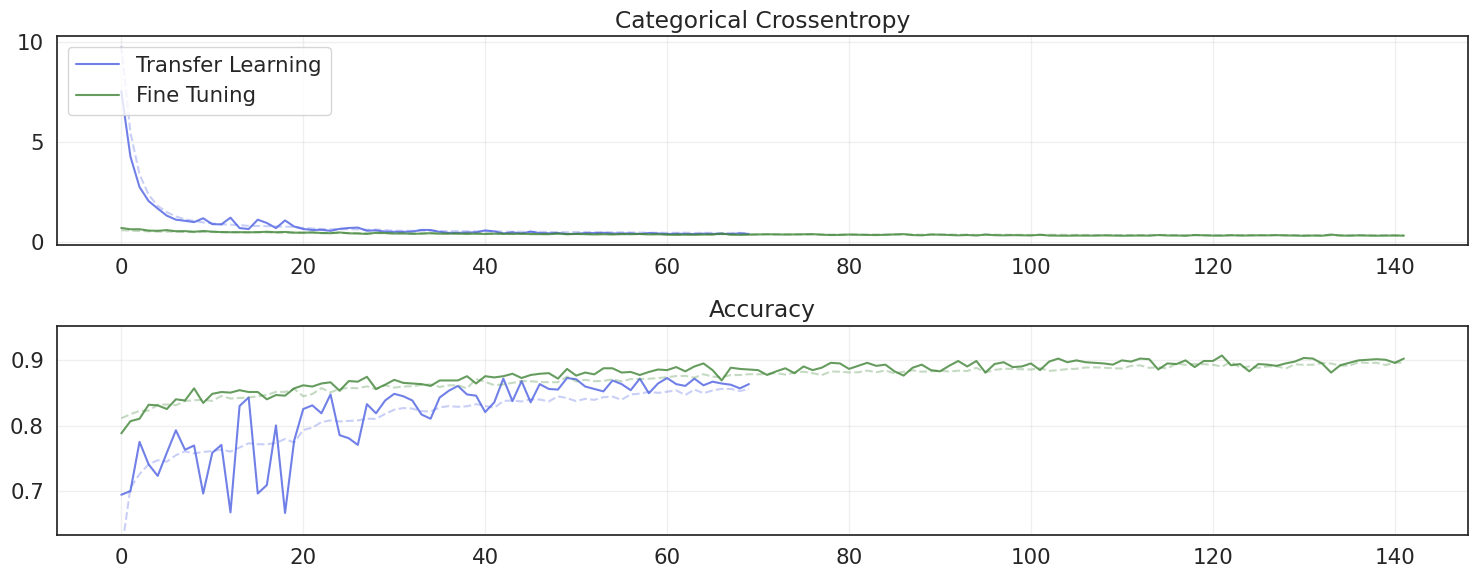

In [ ]:
# Create figure and subplots for loss and accuracy
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 6))

# Plot categorical cross-entropy loss for both Transfer Learning and Fine Tuning stages
ax1.plot(tl_history['loss'], alpha=0.3, color='#4D61E2', linestyle='--')
ax1.plot(tl_history['val_loss'], label='Transfer Learning', alpha=0.8, color='#4D61E2')
ax1.plot(ft_history['loss'], alpha=0.3, color='#408537', linestyle='--')
ax1.plot(ft_history['val_loss'], label='Fine Tuning', alpha=0.8, color='#408537')
ax1.set_title('Categorical Crossentropy')
ax1.legend(loc='upper left')
ax1.grid(alpha=0.3)

# Plot accuracy for both Transfer Learning and Fine Tuning stages
ax2.plot(tl_history['accuracy'], alpha=0.3, color='#4D61E2', linestyle='--')
ax2.plot(tl_history['val_accuracy'], label='Transfer Learning', alpha=0.8, color='#4D61E2')
ax2.plot(ft_history['accuracy'], alpha=0.3, color='#408537', linestyle='--')
ax2.plot(ft_history['val_accuracy'], label='Fine Tuning', alpha=0.8, color='#408537')
ax2.set_title('Accuracy')
ax2.set_ylim([min(tl_history['val_accuracy']) * 0.95, max(ft_history['val_accuracy']) * 1.05])
ax2.grid(alpha=0.3)

# Adjust layout to prevent overlap and display the plots
plt.tight_layout()
plt.show()

Predictions Shape: (1196, 8)
Accuracy score over the test set: 90.22
Precision score over the test set: 90.4549


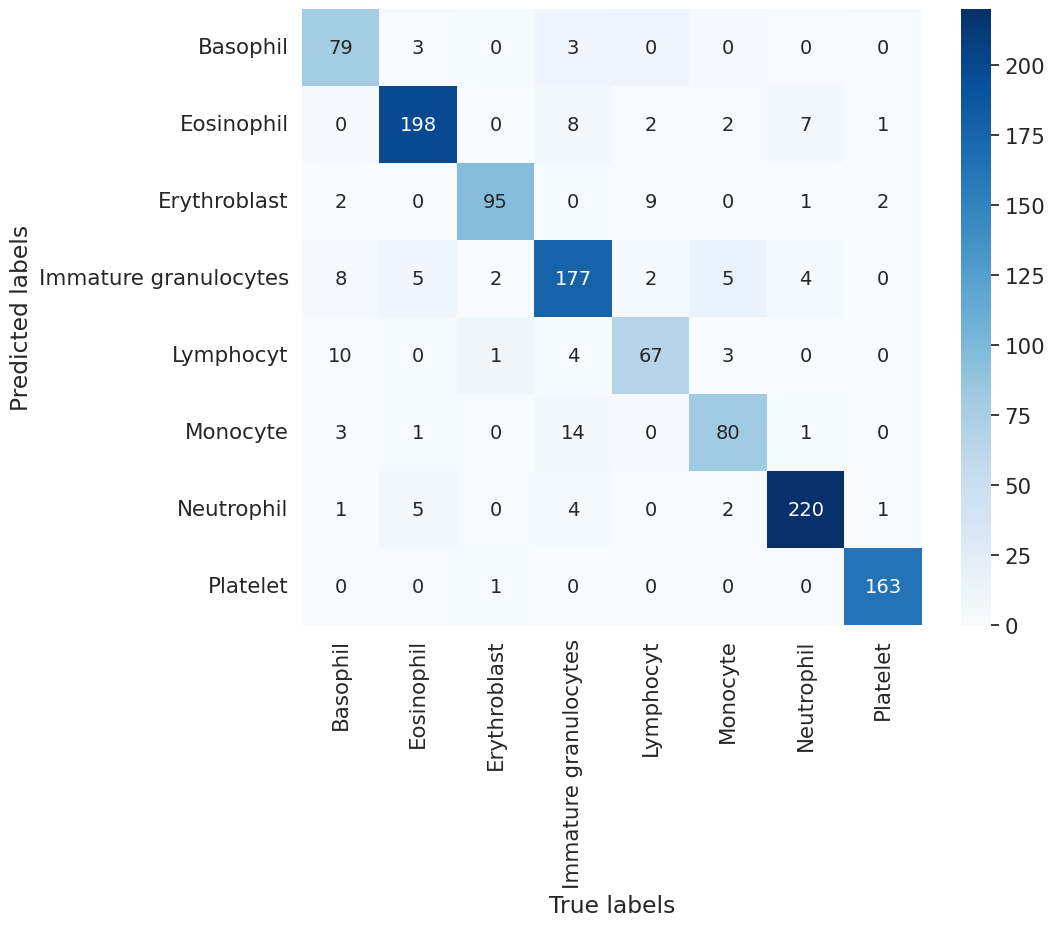

In [ ]:
# Predict labels for the entire test set
predictions = ft_model.predict(X_test*255, verbose=0)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

# Convert predictions to class labels
pred_classes = np.argmax(predictions, axis=-1)

# Extract ground truth classes
true_classes = np.argmax(y_test, axis=-1)

# Calculate and display test set accuracy
accuracy = accuracy_score(true_classes, pred_classes)*100
print(f'Accuracy score over the test set: {round(accuracy, 2)}')

# Calculate and display test set precision
precision = precision_score(true_classes, pred_classes, average='weighted')*100
print(f'Precision score over the test set: {round(precision, 4)}')

# Compute the confusion matrix
cm = confusion_matrix(true_classes, pred_classes)

# Combine numbers and percentages into a single string for annotation
annot = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, annot=annot, fmt='', xticklabels=list(labels.values()), yticklabels=list(labels.values()), cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [ ]:
%%writefile model.py
import numpy as np

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl


class Model:
    def __init__(self):
        """
        Initialize the internal state of the model. Note that the __init__
        method cannot accept any arguments.

        The following is an example loading the weights of a pre-trained
        model.
        """
        self.neural_network = tfk.models.load_model('Tia.keras')

    def predict(self, X):
        """
        Predict the labels corresponding to the input X. Note that X is a numpy
        array of shape (n_samples, 96, 96, 3) and the output should be a numpy
        array of shape (n_samples,). Therefore, outputs must no be one-hot
        encoded.

        The following is an example of a prediction from the pre-trained model
        loaded in the __init__ method.
        """
        preds = self.neural_network.predict(X)
        if len(preds.shape) == 2:
            preds = np.argmax(preds, axis=1)
        return preds

Overwriting model.py


In [ ]:
from datetime import datetime
filename = f'submission_{datetime.now().strftime("%y%m%d_%H%M%S")}.zip'

# Add files to the zip command if needed
!zip {filename} model.py Tia.keras

from google.colab import files
files.download(filename)

  adding: model.py (deflated 56%)
  adding: Tia.keras (deflated 9%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>